# UNETR for image segmentation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_examples_image_segmentation.ipynb)

This tutorial demonstrates how to implement and train a model on image segmentation task. Below, we will be using the [Oxford Pets dataset](https://www.robots.ox.ac.uk/%7Evgg/data/pets/) containing images and masks of cats and dogs. We will implement from scratch the [UNETR](https://arxiv.org/abs/2103.10504) model using Flax NNX. We will train the model on a training set and compute image segmentation metrics on the training and validation sets. We will use [Orbax checkpoint manager](https://orbax.readthedocs.io/en/latest/api_reference/checkpoint.checkpoint_manager.html) to store best models during the training.

## Prepare image segmentation dataset and dataloaders

In this section we use the [Oxford Pets dataset](https://www.robots.ox.ac.uk/%7Evgg/data/pets/).
We download images and masks and provide a code to work with the dataset.
This approach can be easily extended to any image segmentation datasets and users can reuse this code for their own datasets.

In the code below we make a choice of using OpenCV and Pillow to read images and masks as NumPy arrays, [Albumentations](https://github.com/albumentations-team/albumentations) for data augmentations and
[`grain`](https://github.com/google/grain/) for batched data loading. Alternatively, one can use  [tensorflow_dataset](https://www.tensorflow.org/datasets) or [torchvision](https://pytorch.org/vision/stable/index.html) for the same task.

### Requirements installation

We will need to install the following Python packages:

In [1]:
!pip install -U opencv-python-headless grain albumentations Pillow
!pip install -U flax optax orbax-checkpoint

In [2]:
import jax
import flax
import optax
import orbax.checkpoint as ocp
print("Jax version:", jax.__version__)
print("Flax version:", flax.__version__)
print("Optax version:", optax.__version__)
print("Orbax version:", ocp.__version__)

Jax version: 0.4.34
Flax version: 0.10.1
Optax version: 0.2.4
Orbax version: 0.9.1


### Data download

Let's download the data and extract images and masks.

In [3]:
!rm -rf /tmp/data/oxford_pets
!mkdir -p /tmp/data/oxford_pets
!wget https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz -O /tmp/data/oxford_pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz -O /tmp/data/oxford_pets/annotations.tar.gz

!cd /tmp/data/oxford_pets && tar -xf images.tar.gz
!cd /tmp/data/oxford_pets && tar -xf annotations.tar.gz
!ls /tmp/data/oxford_pets

We can also inspect the downloaded images folder, listing a subset of these files:

In [4]:
!ls /tmp/data/oxford_pets/images | wc -l
!ls /tmp/data/oxford_pets/images | head
!ls /tmp/data/oxford_pets/annotations/trimaps | wc -l
!ls /tmp/data/oxford_pets/annotations/trimaps | head

7393
Abyssinian_1.jpg
Abyssinian_10.jpg
Abyssinian_100.jpg
Abyssinian_100.mat
Abyssinian_101.jpg
Abyssinian_101.mat
Abyssinian_102.jpg
Abyssinian_102.mat
Abyssinian_103.jpg
Abyssinian_104.jpg
ls: write error: Broken pipe
7390
Abyssinian_1.png
Abyssinian_10.png
Abyssinian_100.png
Abyssinian_101.png
Abyssinian_102.png
Abyssinian_103.png
Abyssinian_104.png
Abyssinian_105.png
Abyssinian_106.png
Abyssinian_107.png
ls: write error: Broken pipe


### Train/Eval datasets

Let's implement the dataset class providing the access to the images and masks. The class implements `__len__` and `__getitem__` methods.
In this example, we do not have a hard training and validation data split, so we will use the total dataset and make a random training/validation split by indices.
For this purpose we provide a helper class to map indices into training and validation parts.

In [5]:
from typing import Any
from pathlib import Path

import cv2
import numpy as np
from PIL import Image  # we'll read images with opencv and use Pillow as a fallback


class OxfordPetsDataset:
    def __init__(self, path: Path):
        assert path.exists(), path
        self.path: Path = path
        self.images = sorted((self.path / "images").glob("*.jpg"))
        self.masks = [
            self.path / "annotations" / "trimaps" / path.with_suffix(".png").name
            for path in self.images
        ]
        assert len(self.images) == len(self.masks), (len(self.images), len(self.masks))

    def __len__(self) -> int:
        return len(self.images)

    def read_image_opencv(self, path: Path):
        img = cv2.imread(str(path))
        if img is not None:
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            None

    def read_image_pillow(self, path: Path):
        img = Image.open(str(path))
        img = img.convert("RGB")
        return np.asarray(img)

    def read_mask(self, path: Path):
        mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        # mask has values: 1, 2, 3
        # 1 - object mask
        # 2 - background
        # 3 - boundary
        # Define mask as 0-based int values
        mask = mask - 1
        return mask.astype("uint8")

    def __getitem__(self, index: int) -> dict[str, np.ndarray]:
        img_path, mask_path = self.images[index], self.masks[index]
        img = self.read_image_opencv(img_path)
        if img is None:
            # Fallback to Pillow if OpenCV fails to read an image
            img = self.read_image_pillow(img_path)
        mask = self.read_mask(mask_path)
        return {
            "image": img,
            "mask": mask,
        }


class SubsetDataset:
    def __init__(self, dataset, indices: list[int]):
        # Check input indices values:
        for i in indices:
            assert 0 <= i < len(dataset)
        self.dataset = dataset
        self.indices = indices

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, index: int) -> Any:
        i = self.indices[index]
        return self.dataset[i]

Now, let's define the total dataset and compute data indices for training and validation splits:

In [6]:
seed = 12
train_split = 0.7
dataset_path = Path("/tmp/data/oxford_pets")

dataset = OxfordPetsDataset(dataset_path)

rng = np.random.default_rng(seed=seed)
le = len(dataset)
data_indices = list(range(le))

# Let's remove few indices corresponding to corrupted images
# to avoid libjpeg warnings during the data loading
corrupted_data_indices = [3017, 3425]
for index in corrupted_data_indices:
    data_indices.remove(index)

random_indices = rng.permutation(data_indices)

train_val_split_index = int(train_split * le)
train_indices = random_indices[:train_val_split_index]
val_indices = random_indices[train_val_split_index:]

# Ensure there is no overlapping
assert len(set(train_indices) & set(val_indices)) == 0

train_dataset = SubsetDataset(dataset, indices=train_indices)
val_dataset = SubsetDataset(dataset, indices=val_indices)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 5173
Validation dataset size: 2215


To verify our work so far, let's display few training and validation images and masks:

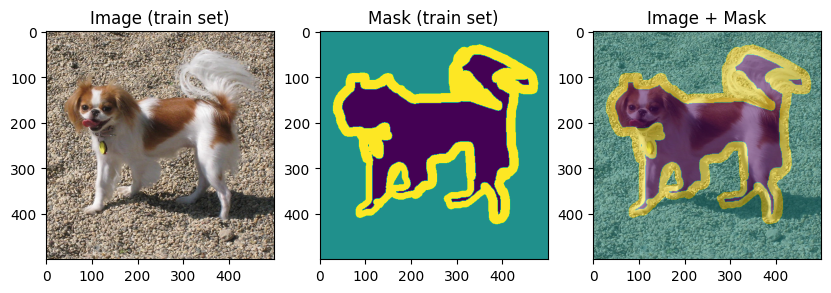

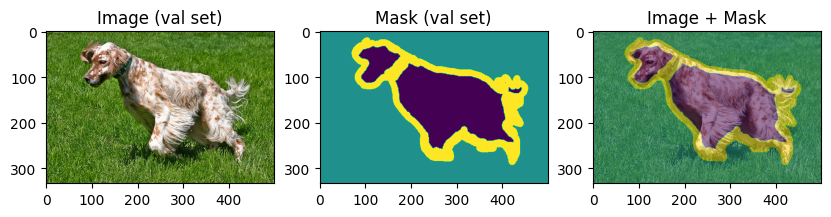

In [7]:
import matplotlib.pyplot as plt


def display_datapoint(datapoint, label=""):
    img, mask = datapoint["image"], datapoint["mask"]
    if img.dtype in (np.float32, ):
        img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].set_title(f"Image{label}")
    axs[0].imshow(img)
    axs[1].set_title(f"Mask{label}")
    axs[1].imshow(mask)
    axs[2].set_title("Image + Mask")
    axs[2].imshow(img)
    axs[2].imshow(mask, alpha=0.5)



display_datapoint(train_dataset[0], label=" (train set)")
display_datapoint(val_dataset[0], label=" (val set)")

### Data augmentations

Next, let's define a simple data augmentation pipeline of joined image and mask transformations using [Albumentations](https://albumentations.ai/docs/examples/example/). We apply geometric and color transformations to increase the diversity of the training data. For more details on the Albumentations transformations, we can check [Albumentations reference API](https://albumentations.ai/docs/api_reference/full_reference/).

In [8]:
import albumentations as A


img_size = 256

train_transforms = A.Compose([
    A.Affine(rotate=(-35, 35), cval_mask=1, p=0.3),  # Random rotations -35 to 35 degrees
    A.RandomResizedCrop(width=img_size, height=img_size, scale=(0.7, 1.0)),  # Crop a random part of the input and rescale it to a specified size
    A.HorizontalFlip(p=0.5),  # Horizontal random flip
    A.RandomBrightnessContrast(p=0.4),  # Randomly changes the brightness and contrast
    A.Normalize(),  # Normalize the image and cast to float
])


val_transforms = A.Compose([
    A.Resize(width=img_size, height=img_size),
    A.Normalize(),  # Normalize the image and cast to float
])

In [9]:
output = train_transforms(**train_dataset[0])
img, mask = output["image"], output["mask"]
print("Image array info:", img.dtype, img.shape, img.min(), img.mean(), img.max())
print("Mask array info:", mask.dtype, mask.shape, mask.min(), mask.max())

Image array info: float32 (256, 256, 3) -1.5356623 0.5732621 2.6399999
Mask array info: uint8 (256, 256) 0 2


In [10]:
output = val_transforms(**val_dataset[0])
img, mask = output["image"], output["mask"]
print("Image array info:", img.dtype, img.shape, img.min(), img.mean(), img.max())
print("Mask array info:", mask.dtype, mask.shape, mask.min(), mask.max())

Image array info: float32 (256, 256, 3) -2.117904 -0.30076745 2.6399999
Mask array info: uint8 (256, 256) 0 2


### Data loaders

Let's now use [`grain`](https://github.com/google/grain) to perform data loading, augmentations and batching on a single device using multiple workers. We will create a random index sampler for training and an unshuffled sampler for validation.

In [11]:
from typing import Any, Callable

import grain.python as grain


class DataAugs(grain.MapTransform):
    def __init__(self, transforms: Callable):
        self.albu_transforms = transforms

    def map(self, data):
        output = self.albu_transforms(**data)
        return output

In [12]:
train_batch_size = 72
val_batch_size = 2 * train_batch_size


# Create an IndexSampler with no sharding for single-device computations
train_sampler = grain.IndexSampler(
    len(train_dataset),  # The total number of samples in the data source
    shuffle=True,            # Shuffle the data to randomize the order of samples
    seed=seed,               # Set a seed for reproducibility
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,            # Iterate over the dataset for one epoch
)

val_sampler = grain.IndexSampler(
    len(val_dataset),  # The total number of samples in the data source
    shuffle=False,         # Do not shuffle the data
    seed=seed,             # Set a seed for reproducibility
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,          # Iterate over the dataset for one epoch
)

In [13]:
train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        DataAugs(train_transforms),
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

# Validation dataset loader
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,                   # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,
    operations=[
        DataAugs(val_transforms),
        grain.Batch(val_batch_size),
    ]
)

# Training dataset loader for evaluation (without dataaugs)
train_eval_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        DataAugs(val_transforms),
        grain.Batch(val_batch_size),
    ]
)

In [14]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [15]:
print("Train images batch info:", type(train_batch["image"]), train_batch["image"].shape, train_batch["image"].dtype)
print("Train masks batch info:", type(train_batch["mask"]), train_batch["mask"].shape, train_batch["mask"].dtype)

Train images batch info: <class 'grain._src.python.shared_memory_array.SharedMemoryArray'> (72, 256, 256, 3) float32
Train masks batch info: <class 'grain._src.python.shared_memory_array.SharedMemoryArray'> (72, 256, 256) uint8


Finally, let's display the training and validation data:

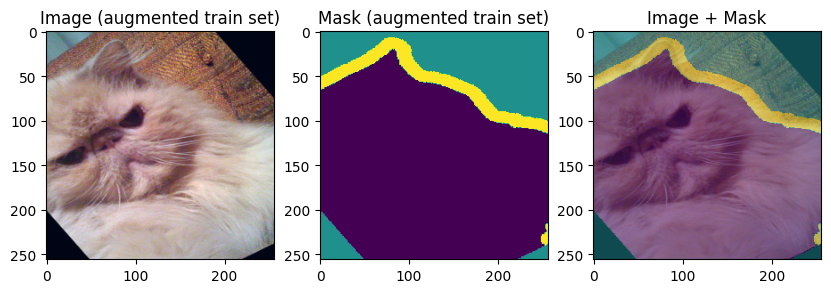

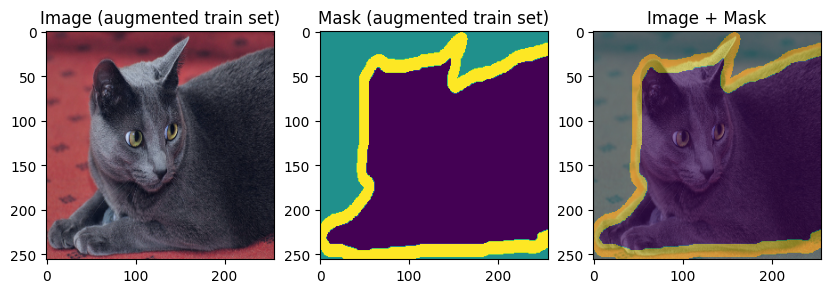

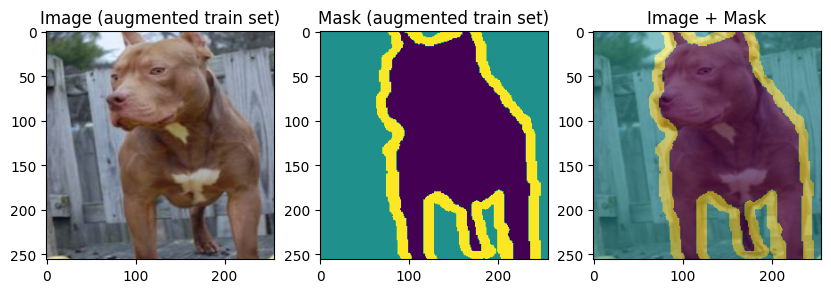

In [16]:
images, masks = train_batch["image"], train_batch["mask"]

for img, mask in zip(images[:3], masks[:3]):
    display_datapoint({"image": img, "mask": mask}, label=" (augmented train set)")

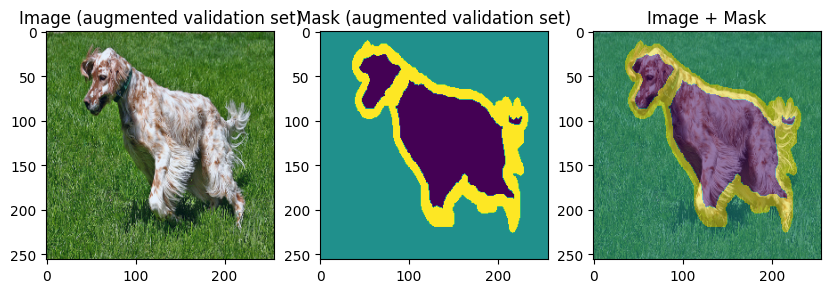

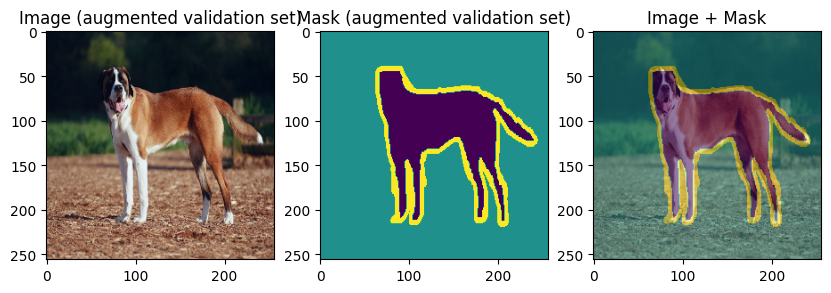

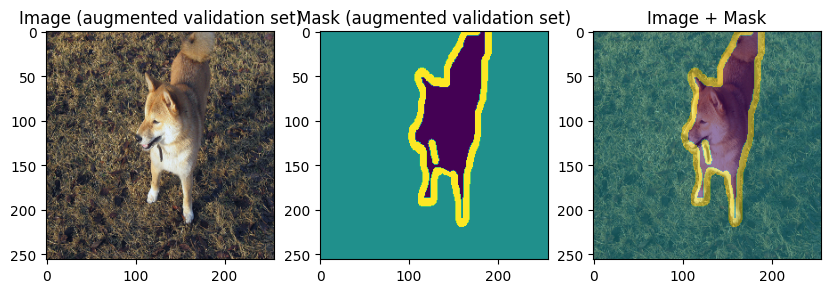

In [17]:
images, masks = val_batch["image"], val_batch["mask"]

for img, mask in zip(images[:3], masks[:3]):
    display_datapoint({"image": img, "mask": mask}, label=" (augmented validation set)")

## Model for Image Segmentation

In this section we will implement the [UNETR](https://arxiv.org/abs/2103.10504) model from scratch using Flax NNX. The reference PyTorch implementation of this model can be found on the [MONAI Library GitHub repository](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/unetr.py).

The UNETR model utilizes a transformer as the encoder to learn sequence representations of the input and to capture the global multi-scale information, while also following the “U-shaped” network design like [UNet](https://arxiv.org/abs/1505.04597) model:
![image.png](./_static/images/unetr_architecture.png)

The UNETR architecture on the image above is processing 3D inputs, but it can be easily adapted to 2D input.

The transformer encoder of UNETR is [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929). The feature maps returned by ViT have all the same spatial size: (H / 16, W / 16) and deconvolutions are used to upsample the feature maps. Finally, the feature maps are upsampled and concatenated up to the original image size.

In [18]:
from flax import nnx
import jax.numpy as jnp

### Vision Transformer encoder implementation

Below, we will implement the following modules:
- Vision Transformer, `ViT`
  - `PatchEmbeddingBlock`: patch embedding block, which maps patches of pixels to a sequence of vectors
  - `ViTEncoderBlock`: vision transformer encoder block
    - `MLPBlock`: multilayer perceptron block

In [19]:
class PatchEmbeddingBlock(nnx.Module):
    """
    A patch embedding block, based on: "Dosovitskiy et al.,
    An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>"
    """
    def __init__(
        self,
        in_channels: int,  # dimension of input channels.
        img_size: int,  # dimension of input image.
        patch_size: int,  # dimension of patch size.
        hidden_size: int,  # dimension of hidden layer.
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        n_patches = (img_size // patch_size) ** 2
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches, hidden_size), jnp.float32)
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.patch_embeddings(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


mod = PatchEmbeddingBlock(3, 256, 16, 768, 0.5)
x = jnp.ones((4, 256, 256, 3))
y = mod(x)
print(y.shape)

(4, 256, 768)


In [20]:
from typing import Callable


class MLPBlock(nnx.Sequential):
    """
    A multi-layer perceptron block, based on: "Dosovitskiy et al.,
    An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>"
    """
    def __init__(
        self,
        hidden_size: int,  # dimension of hidden layer.
        mlp_dim: int,      # dimension of feedforward layer
        dropout_rate: float = 0.0,
        activation_layer: Callable = nnx.gelu,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        layers = [
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            activation_layer,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        ]
        super().__init__(*layers)


mod = MLPBlock(768, 3072, 0.5)
x = jnp.ones((4, 256, 768))
y = mod(x)
print(y.shape)

(4, 256, 768)


In [21]:
class ViTEncoderBlock(nnx.Module):
    """
    A transformer encoder block, based on: "Dosovitskiy et al.,
    An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>"
    """
    def __init__(
        self,
        hidden_size: int,  # dimension of hidden layer.
        mlp_dim: int,      # dimension of feedforward layer.
        num_heads: int,    # number of attention heads
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:
        self.mlp = MLPBlock(hidden_size, mlp_dim, dropout_rate, rngs=rngs)
        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            rngs=rngs,
        )
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


mod = ViTEncoderBlock(768, 3072, 12)
x = jnp.ones((4, 256, 768))
y = mod(x)
print(y.shape)

(4, 256, 768)


In [22]:
class ViT(nnx.Module):
    """
    Vision Transformer (ViT) Feature Extractor, based on: "Dosovitskiy et al.,
    An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>"
    """
    def __init__(
        self,
        in_channels: int,  # dimension of input channels
        img_size: int,  # dimension of input image
        patch_size: int,  # dimension of patch size
        hidden_size: int = 768,  # dimension of hidden layer
        mlp_dim: int = 3072,  # dimension of feedforward layer
        num_layers: int = 12,  # number of transformer blocks
        num_heads: int = 12,   # number of attention heads
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.patch_embedding = PatchEmbeddingBlock(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=patch_size,
            hidden_size=hidden_size,
            dropout_rate=dropout_rate,
            rngs=rngs,
        )
        self.blocks = [
            ViTEncoderBlock(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ]
        self.norm = nnx.LayerNorm(hidden_size, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.patch_embedding(x)
        hidden_states_out = []
        for blk in self.blocks:
            x = blk(x)
            hidden_states_out.append(x)
        x = self.norm(x)
        return x, hidden_states_out


mod = ViT(3, 224, 16)
x = jnp.ones((4, 224, 224, 3))
y, hstates = mod(x)
print(y.shape, [s.shape for s in hstates])

(4, 196, 768) [(4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768), (4, 196, 768)]


At this point we implemented the encoder of the UNETR model. As we can see from the above output, ViT provides one encoded feature map and a list of intermediate feature maps. Three of them will be used in the decoding part.

### UNETR blocks implementation

Now, we can implement remaining blocks and assemble them together in the UNETR implementation

Below, we will implement the following modules:
- `UNETR`
  - `UnetrBasicBlock`: creates the first skip connection from the input.
    - `UnetResBlock`
  - `UnetrPrUpBlock`: projection upsampling modules to create skip connections from the intermediate feature maps provided by ViT.
  - `UnetrUpBlock`: upsampling modules used in the decoder

In [23]:
class Conv2dNormActivation(nnx.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int | None = None,
        groups: int = 1,
        norm_layer: Callable[..., nnx.Module] = nnx.BatchNorm,
        activation_layer: Callable = nnx.relu,
        dilation: int = 1,
        bias: bool | None = None,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.out_channels = out_channels

        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None

        # sequence integer pairs that give the padding to apply before
        # and after each spatial dimension
        padding = ((padding, padding), (padding, padding))

        layers = [
            nnx.Conv(
                in_channels,
                out_channels,
                kernel_size=(kernel_size, kernel_size),
                strides=(stride, stride),
                padding=padding,
                kernel_dilation=(dilation, dilation),
                feature_group_count=groups,
                use_bias=bias,
                rngs=rngs,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels, rngs=rngs))

        if activation_layer is not None:
            layers.append(activation_layer)

        super().__init__(*layers)

In [24]:
class InstanceNorm(nnx.GroupNorm):
    def __init__(self, num_features, **kwargs):
        num_groups, group_size = num_features, None
        super().__init__(
            num_features,
            num_groups=num_groups,
            group_size=group_size,
            **kwargs,
        )


class UnetResBlock(nnx.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        norm_layer: Callable[..., nnx.Module] = InstanceNorm,
        activation_layer: Callable = nnx.leaky_relu,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.conv_norm_act1 = Conv2dNormActivation(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            norm_layer=norm_layer,
            activation_layer=activation_layer,
            rngs=rngs,
        )
        self.conv_norm2 = Conv2dNormActivation(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            norm_layer=norm_layer,
            activation_layer=None,
            rngs=rngs,
        )

        self.downsample = (in_channels != out_channels) or (stride != 1)
        if self.downsample:
            self.conv_norm3 = Conv2dNormActivation(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=stride,
                norm_layer=norm_layer,
                activation_layer=None,
                rngs=rngs,
            )
        self.act = activation_layer

    def __call__(self, x: jax.Array) -> jax.Array:
        residual = x
        out = self.conv_norm_act1(x)
        out = self.conv_norm2(out)
        if self.downsample:
            residual = self.conv_norm3(residual)
        out += residual
        out = self.act(out)
        return out


mod = UnetResBlock(16, 32, 3, 1)
x = jnp.ones((4, 24, 24, 16))
y = mod(x)
print(y.shape)

(4, 24, 24, 32)


In [25]:
class UnetrBasicBlock(nnx.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        norm_layer: Callable[..., nnx.Module] = InstanceNorm,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.layer = UnetResBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            norm_layer=norm_layer,
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        return self.layer(x)


mod = UnetrBasicBlock(16, 32, 3, 1)
x = jnp.ones((4, 24, 24, 16))
y = mod(x)
print(y.shape)

(4, 24, 24, 32)


In [26]:
class UnetrPrUpBlock(nnx.Module):
    """
    A projection upsampling module for UNETR: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,  # number of input channels.
        out_channels: int, # number of output channels.
        num_layer: int,    # number of upsampling blocks.
        kernel_size: int,
        stride: int,
        upsample_kernel_size: int = 2,  # convolution kernel size for transposed convolution layers.
        norm_layer: Callable[..., nnx.Module] = InstanceNorm,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        upsample_stride = upsample_kernel_size
        self.transp_conv_init = nnx.ConvTranspose(
            in_features=in_channels,
            out_features=out_channels,
            kernel_size=(upsample_kernel_size, upsample_kernel_size),
            strides=(upsample_stride, upsample_stride),
            padding="VALID",
            rngs=rngs,
        )
        self.blocks = [
            nnx.Sequential(
                nnx.ConvTranspose(
                    in_features=out_channels,
                    out_features=out_channels,
                    kernel_size=(upsample_kernel_size, upsample_kernel_size),
                    strides=(upsample_stride, upsample_stride),
                    rngs=rngs,
                ),
                UnetResBlock(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    norm_layer=norm_layer,
                    rngs=rngs,
                ),
            )
            for i in range(num_layer)
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.transp_conv_init(x)
        for blk in self.blocks:
            x = blk(x)
        return x


mod = UnetrPrUpBlock(16, 32, 2, 3, 1)
x = jnp.ones((4, 24, 24, 16))
y = mod(x)
print(y.shape)

(4, 192, 192, 32)


In [27]:
class UnetrUpBlock(nnx.Module):
    """
    An upsampling module for UNETR: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        upsample_kernel_size: int = 2,  # convolution kernel size for transposed convolution layers.
        norm_layer: Callable[..., nnx.Module] = InstanceNorm,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:
        upsample_stride = upsample_kernel_size
        self.transp_conv = nnx.ConvTranspose(
            in_features=in_channels,
            out_features=out_channels,
            kernel_size=(upsample_kernel_size, upsample_kernel_size),
            strides=(upsample_stride, upsample_stride),
            padding="VALID",
            rngs=rngs,
        )
        self.conv_block = UnetResBlock(
            out_channels + out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            norm_layer=norm_layer,
            rngs=rngs,
        )

    def __call__(self, x: jax.Array, skip: jax.Array) -> jax.Array:
        out = self.transp_conv(x)
        out = jnp.concat((out, skip), axis=-1)
        out = self.conv_block(out)
        return out


mod = UnetrUpBlock(16, 32, 3)
x = jnp.ones((4, 24, 24, 16))
skip = jnp.ones((4, 2 * 24, 2 * 24, 32))
y = mod(x, skip)
print(y.shape)

(4, 48, 48, 32)


In [28]:
class UNETR(nnx.Module):
    """UNETR model ported to NNX from MONAI implementation:
    - https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/unetr.py
    """
    def __init__(
        self,
        out_channels: int,
        in_channels: int = 3,
        img_size: int = 256,
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        dropout_rate: float = 0.0,
        norm_layer: Callable[..., nnx.Module] = InstanceNorm,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.num_layers = 12
        self.patch_size = 16
        self.feat_size = img_size // self.patch_size
        self.hidden_size = hidden_size

        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            rngs=rngs,
        )
        self.encoder1 = UnetrBasicBlock(
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.encoder2 = UnetrPrUpBlock(
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.encoder3 = UnetrPrUpBlock(
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.encoder4 = UnetrPrUpBlock(
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.decoder5 = UnetrUpBlock(
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.decoder4 = UnetrUpBlock(
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.decoder3 = UnetrUpBlock(
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )
        self.decoder2 = UnetrUpBlock(
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_layer=norm_layer,
            rngs=rngs,
        )

        self.out = nnx.Conv(
            in_features=feature_size,
            out_features=out_channels,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        self.proj_axes = (0, 1, 2, 3)
        self.proj_view_shape = [self.feat_size, self.feat_size, self.hidden_size]

    def proj_feat(self, x: jax.Array) -> jax.Array:
        new_view = [x.shape[0]] + self.proj_view_shape
        x = x.reshape(new_view)
        x = jnp.permute_dims(x, self.proj_axes)
        return x

    def __call__(self, x_in: jax.Array) -> jax.Array:
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4))
        dec4 = self.proj_feat(x)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        return self.out(out)

In [29]:
# We'll use a different number of heads to make a smaller model
model = UNETR(out_channels=3, num_heads=4)
x = jnp.ones((4, 256, 256, 3))
y = model(x)
print(y.shape)

(4, 256, 256, 3)


We can visualize and inspect the architecture on the implemented model using `nnx.display(model)`.

## Train the model

In previous sections we defined training and validation dataloaders and the model. In this section we will train the model and define the loss function and the optimizer to perform the parameters optimization.

For the semantic segmentation task, we can define the loss function as a sum of Cross-Entropy and Jaccard loss functions. The Cross-Entropy loss function is a standard loss function for a multi-class classification tasks and the Jaccard loss function helps directly optimizing Intersection-over-Union measure for semantic segmentation.

In [30]:
import optax

num_epochs = 50
total_steps = len(train_dataset) // train_batch_size
learning_rate = 0.003
momentum = 0.9

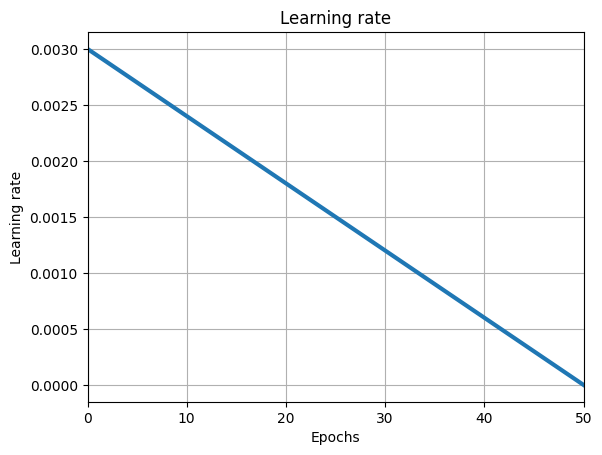

In [31]:
lr_schedule = optax.linear_schedule(learning_rate, 0.0, num_epochs * total_steps)

iterate_subsample = np.linspace(0, num_epochs * total_steps, 100)
plt.plot(
    np.linspace(0, num_epochs, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, num_epochs))
plt.show()


optimizer = nnx.Optimizer(model, optax.adam(lr_schedule, momentum))

Let us implement Jaccard loss and the loss function combining Cross-Entropy and Jaccard losses.

In [32]:
def compute_softmax_jaccard_loss(logits, masks, reduction="mean"):
    assert reduction in ("mean", "sum")
    y_pred = nnx.softmax(logits, axis=-1)
    b, c = y_pred.shape[0], y_pred.shape[-1]
    y = nnx.one_hot(masks, num_classes=c, axis=-1)

    y_pred = y_pred.reshape((b, -1, c))
    y = y.reshape((b, -1, c))

    intersection = y_pred * y
    union = y_pred + y - intersection + 1e-8

    intersection = jnp.sum(intersection, axis=1)
    union = jnp.sum(union, axis=1)

    if reduction == "mean":
        intersection = jnp.mean(intersection)
        union = jnp.mean(union)
    elif reduction == "sum":
        intersection = jnp.sum(intersection)
        union = jnp.sum(union)

    return 1.0 - intersection / union


def compute_losses_and_logits(model: nnx.Module, images: jax.Array, masks: jax.Array):
    logits = model(images)

    xentropy_loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=masks
    ).mean()

    jacc_loss = compute_softmax_jaccard_loss(logits=logits, masks=masks)
    loss = xentropy_loss + jacc_loss
    return loss, (xentropy_loss, jacc_loss, logits)

Now, we will implement a confusion matrix metric derived from [`nnx.Metric`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/training/metrics.html#flax.nnx.metrics.Metric). A confusion matrix will help us to compute the Intersection-Over-Union (IoU) metric per class and on average. Finally, we can also compute the accuracy metric using the confusion matrix.

In [33]:
class ConfusionMatrix(nnx.Metric):
    def __init__(
        self,
        num_classes: int,
        average: str | None = None,
    ):
        assert average in (None, "samples", "recall", "precision")
        assert num_classes > 0
        self.num_classes = num_classes
        self.average = average
        self.confusion_matrix = nnx.metrics.MetricState(
            jnp.zeros((self.num_classes, self.num_classes), dtype=jnp.int32)
        )
        self.count = nnx.metrics.MetricState(jnp.array(0, dtype=jnp.int32))

    def reset(self):
        self.confusion_matrix.value = jnp.zeros((self.num_classes, self.num_classes), dtype=jnp.int32)
        self.count.value = jnp.array(0, dtype=jnp.int32)

    def _check_shape(self, y_pred: jax.Array, y: jax.Array):
        if y_pred.shape[-1] != self.num_classes:
            raise ValueError(f"y_pred does not have correct number of classes: {y_pred.shape[-1]} vs {self.num_classes}")

        if not (y.ndim + 1 == y_pred.ndim):
            raise ValueError(
                f"y_pred must have shape (batch_size, num_classes (currently set to {self.num_classes}), ...) "
                "and y must have shape of (batch_size, ...), "
                f"but given {y.shape} vs {y_pred.shape}."
            )

    def update(self, **kwargs):
        # We assume that y.max() < self.num_classes and y.min() >= 0
        assert "y" in kwargs
        assert "y_pred" in kwargs
        y_pred = kwargs["y_pred"]
        y = kwargs["y"]
        self._check_shape(y_pred, y)
        self.count.value += y_pred.shape[0]

        y_pred = jnp.argmax(y_pred, axis=-1).ravel()
        y = y.ravel()
        indices = self.num_classes * y + y_pred
        matrix = jnp.bincount(indices, minlength=self.num_classes**2, length=self.num_classes**2)
        matrix = matrix.reshape((self.num_classes, self.num_classes))
        self.confusion_matrix.value += matrix

    def compute(self) -> jax.Array:
        if self.average:
            confusion_matrix = self.confusion_matrix.value.astype("float")
            if self.average == "samples":
                return confusion_matrix / self.count.value
            else:
                return self.normalize(self.confusion_matrix.value, self.average)
        return self.confusion_matrix.value

    @staticmethod
    def normalize(matrix: jax.Array, average: str) -> jax.Array:
        """Normalize given `matrix` with given `average`."""
        if average == "recall":
            return matrix / (jnp.expand_dims(matrix.sum(axis=1), axis=1) + 1e-15)
        elif average == "precision":
            return matrix / (matrix.sum(axis=0) + 1e-15)
        else:
            raise ValueError("Argument average should be one of 'samples', 'recall', 'precision'")


def compute_iou(cm: jax.Array) -> jax.Array:
    return jnp.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - jnp.diag(cm) + 1e-15)


def compute_mean_iou(cm: jax.Array) -> jax.Array:
    return compute_iou(cm).mean()


def compute_accuracy(cm: jax.Array) -> jax.Array:
    return jnp.diag(cm).sum() / (cm.sum() + 1e-15)

Next, let's define training and evaluation steps:

In [34]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, np.ndarray]
):
    # Convert numpy arrays to jax.Array on GPU
    images = jnp.array(batch["image"])
    masks = jnp.array(batch["mask"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, (xentropy_loss, jacc_loss, logits)), grads = grad_fn(model, images, masks)

    optimizer.update(grads)  # In-place updates.

    return loss, xentropy_loss, jacc_loss

In [35]:
@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, np.ndarray], eval_metrics: nnx.MultiMetric
):
    # Convert numpy arrays to jax.Array on GPU
    images = jnp.array(batch["image"])
    masks = jnp.array(batch["mask"], dtype=jnp.int32)
    loss, (_, _, logits) = compute_losses_and_logits(model, images, masks)

    eval_metrics.update(
        total_loss=loss,
        y_pred=logits,
        y=masks,
    )  # In-place updates.

We will also define metrics we want to compute during the evaluation phase: total loss and confusion matrix computed on training and validation datasets. Finally, we define helper objects to store the metrics history.
Metrics like IoU per class, mean IoU and accuracy will be computed using the confusion matrix in the evaluation code.

In [36]:
eval_metrics = nnx.MultiMetric(
    total_loss=nnx.metrics.Average('total_loss'),
    confusion_matrix=ConfusionMatrix(num_classes=3),
)


eval_metrics_history = {
    "train_total_loss": [],
    "train_IoU": [],
    "train_mean_IoU": [],
    "train_accuracy": [],

    "val_total_loss": [],
    "val_IoU": [],
    "val_mean_IoU": [],
    "val_accuracy": [],
}

Let us define the training and evaluation logic. We define as well a checkpoint manager to store two best models defined by validation mean IoU metric value.

In [37]:
import time
import orbax.checkpoint as ocp


def train_one_epoch(epoch):
    start_time = time.time()

    model.train()  # Set model to the training mode: e.g. update batch statistics
    for step, batch in enumerate(train_loader):
        total_loss, xentropy_loss, jaccard_loss = train_step(model, optimizer, batch)

        print(
            f"\r[train] epoch: {epoch + 1}/{num_epochs}, iteration: {step}/{total_steps}, "
            f"total loss: {total_loss.item():.4f} ",
            f"xentropy loss: {xentropy_loss.item():.4f} ",
            f"jaccard loss: {jaccard_loss.item():.4f} ",
            end="")
        print("\r", end="")

    elapsed = time.time() - start_time
    print(
        f"\n[train] epoch: {epoch + 1}/{num_epochs}, elapsed time: {elapsed:.2f} seconds"
    )


def evaluate_model(epoch):
    start_time = time.time()

    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    for tag, eval_loader in [("train", train_eval_loader), ("val", val_loader)]:
        eval_metrics.reset()  # Reset the eval metrics
        for val_batch in eval_loader:
            eval_step(model, val_batch, eval_metrics)

        for metric, value in eval_metrics.compute().items():
            if metric == "confusion_matrix":
                eval_metrics_history[f"{tag}_IoU"].append(
                    compute_iou(value)
                )
                eval_metrics_history[f"{tag}_mean_IoU"].append(
                    compute_mean_iou(value)
                )
                eval_metrics_history[f"{tag}_accuracy"].append(
                    compute_accuracy(value)
                )
            else:
                eval_metrics_history[f'{tag}_{metric}'].append(value)

        print(
            f"[{tag}] epoch: {epoch + 1}/{num_epochs} "
            f"\n - total loss: {eval_metrics_history[f'{tag}_total_loss'][-1]:0.4f} "
            f"\n - IoU per class: {eval_metrics_history[f'{tag}_IoU'][-1].tolist()} "
            f"\n - Mean IoU: {eval_metrics_history[f'{tag}_mean_IoU'][-1]:0.4f} "
            f"\n - Accuracy: {eval_metrics_history[f'{tag}_accuracy'][-1]:0.4f} "
            "\n"
        )

    elapsed = time.time() - start_time
    print(
        f"[evaluation] epoch: {epoch + 1}/{num_epochs}, elapsed time: {elapsed:.2f} seconds"
    )

    return eval_metrics_history['val_mean_IoU'][-1]


path = ocp.test_utils.erase_and_create_empty("/tmp/output-oxford-model/")
options = ocp.CheckpointManagerOptions(max_to_keep=2)
mngr = ocp.CheckpointManager(path, options=options)


def save_model(epoch):
    state = nnx.state(model)
    # We should convert PRNGKeyArray to the old format for Dropout layers
    # https://github.com/google/flax/issues/4231
    def get_key_data(x):
        if isinstance(x, jax._src.prng.PRNGKeyArray):
            if isinstance(x.dtype, jax._src.prng.KeyTy):
                return jax.random.key_data(x)
        return x

    serializable_state = jax.tree.map(get_key_data, state)
    mngr.save(epoch, args=ocp.args.StandardSave(serializable_state))
    mngr.wait_until_finished()

Now we can start the training. It can take around 45 minutes using a single GPU and use 19GB of GPU memory.

In [38]:
%%time

best_val_mean_iou = 0.0
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    if (epoch % 3 == 0) or (epoch == num_epochs - 1):
        val_mean_iou = evaluate_model(epoch)
        if val_mean_iou > best_val_mean_iou:
            save_model(epoch)
            best_val_mean_iou = val_mean_iou

2024-11-19 15:13:28.682932: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=2,k3=0} for conv (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,72,256,256]{3,2,1,0}, f32[32,72,255,255]{3,2,1,0}), window={size=255x255 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-19 15:13:29.105239: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.422412472s
Trying algorithm eng28{k2=2,k3=0} for conv (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,72,256,256]{3,2,1,0}, f32[32,72,255,255]{3,2,1,0}), window={size=255x255 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_c

[train] epoch: 1/50, iteration: 67/71, total loss: 1.5128  xentropy loss: 0.8543  jaccard loss: 0.6585 
[train] epoch: 1/50, elapsed time: 98.28 seconds
[train] epoch: 1/50 
 - total loss: 1.4808 
 - IoU per class: [0.3311152458190918, 0.5875526070594788, 0.07520102709531784] 
 - Mean IoU: 0.3313 
 - Accuracy: 0.6198 

[val] epoch: 1/50 
 - total loss: 1.4837 
 - IoU per class: [0.32379695773124695, 0.5863257050514221, 0.07609017938375473] 
 - Mean IoU: 0.3287 
 - Accuracy: 0.6174 

[evaluation] epoch: 1/50, elapsed time: 95.73 seconds
[train] epoch: 2/50, iteration: 67/71, total loss: 1.4376  xentropy loss: 0.8077  jaccard loss: 0.6299 
[train] epoch: 2/50, elapsed time: 42.02 seconds
[train] epoch: 3/50, iteration: 67/71, total loss: 1.3881  xentropy loss: 0.7764  jaccard loss: 0.6118 
[train] epoch: 3/50, elapsed time: 42.77 seconds
[train] epoch: 4/50, iteration: 67/71, total loss: 1.3697  xentropy loss: 0.7662  jaccard loss: 0.6035 
[train] epoch: 4/50, elapsed time: 42.69 seconds

We can check the saved models:

In [39]:
!ls /tmp/output-oxford-model/

/opt/conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


45  49


and visualize collected metrics:

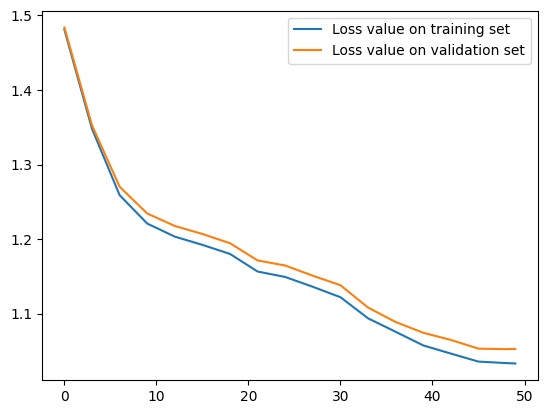

In [40]:
epochs = [i for i in range(num_epochs) if (i % 3 == 0) or (i == num_epochs - 1)]

plt.plot(epochs, eval_metrics_history["train_total_loss"], label="Loss value on training set")
plt.plot(epochs, eval_metrics_history["val_total_loss"], label="Loss value on validation set")
plt.legend()

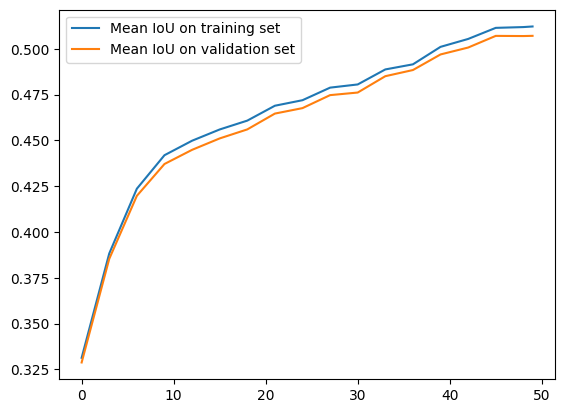

In [41]:
plt.plot(epochs, eval_metrics_history["train_mean_IoU"], label="Mean IoU on training set")
plt.plot(epochs, eval_metrics_history["val_mean_IoU"], label="Mean IoU on validation set")
plt.legend()

Next, we will visualize model predictions on validation data:

In [42]:
model.eval()
val_batch = next(iter(val_loader))

In [43]:
images, masks = val_batch["image"], val_batch["mask"]
preds = model(images)
preds = jnp.argmax(preds, axis=-1)

In [44]:
def display_image_mask_pred(img, mask, pred, label=""):
    if img.dtype in (np.float32, ):
        img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)
    fig, axs = plt.subplots(1, 5, figsize=(15, 10))
    axs[0].set_title(f"Image{label}")
    axs[0].imshow(img)
    axs[1].set_title(f"Mask{label}")
    axs[1].imshow(mask)
    axs[2].set_title("Image + Mask")
    axs[2].imshow(img)
    axs[2].imshow(mask, alpha=0.5)
    axs[3].set_title(f"Pred{label}")
    axs[3].imshow(pred)
    axs[4].set_title("Image + Pred")
    axs[4].imshow(img)
    axs[4].imshow(pred, alpha=0.5)

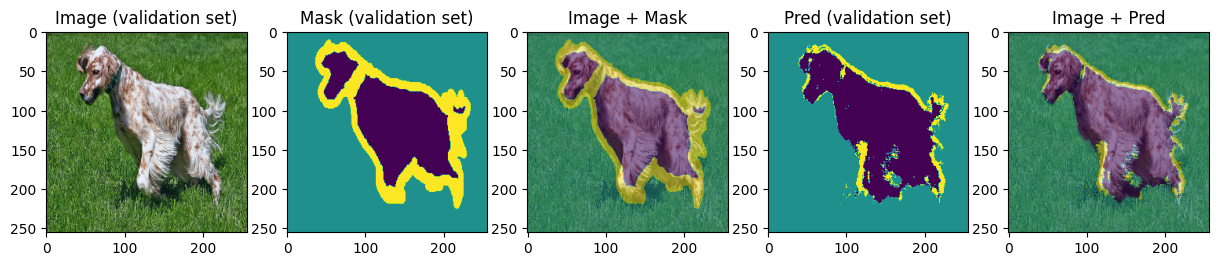

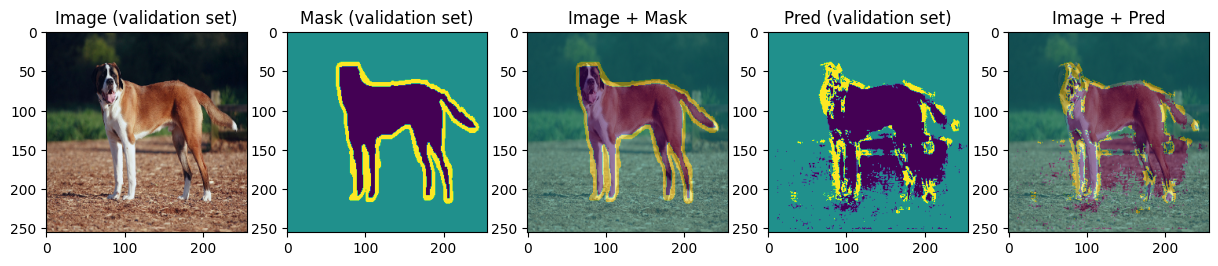

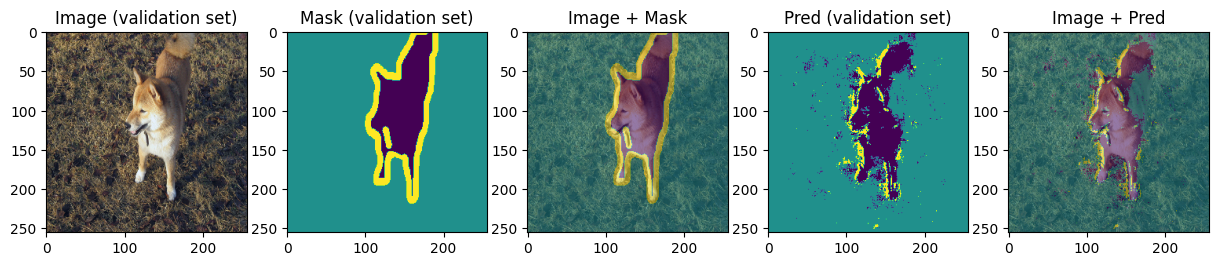

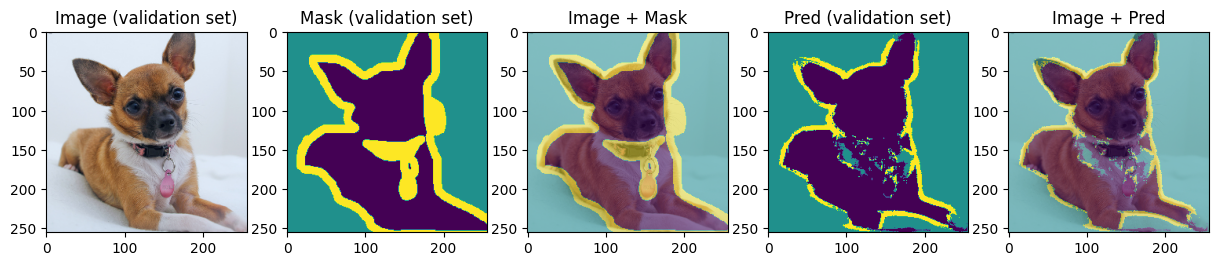

In [45]:
for img, mask, pred in zip(images[:4], masks[:4], preds[:4]):
    display_image_mask_pred(img, mask, pred, label=" (validation set)")

We can see that model can roughly predict the shape of the animal and the background and struggles with predicting the boundary. Carefully choosing hyperparameters we may achieve better results.